In [1]:
from __future__ import division

from past.utils import old_div

# Checking path to access other files
try:
    from sippy import *
except ImportError:
    import sys, os

    sys.path.append(os.pardir)
    from sippy import *

import numpy as np
from sippy import functionset as fset
from sippy import functionsetSIM as fsetSIM
import matplotlib.pyplot as plt

from scipy.io import savemat

(1, 501)
(2, 501)


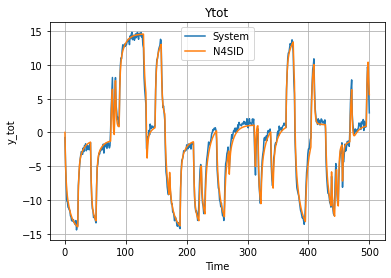

In [8]:
"""
Created on Fri Jan 19 2018
@author: Giuseppe Armenise, revised by RBdC
In this test, no error occurs. 
Using method='N4SID','MOESP' or 'CVA', if the message
"Kalman filter cannot be calculated" is shown, it means
that the package slycot is not well-installed.
"""



# Example to test SS-methods

# sample time
ts = 1.0

# SISO SS system (n = 2)
A = np.array([[0.89, 0.], [0., 0.45]])
B = np.array([[0.3, 0.7], [2.5, 1.4]])
C = np.array([[0.7, 1.]])
D = np.array([[0.0, 1.0]])

tfin = 500
npts = int(old_div(tfin, ts)) + 1
Time = np.linspace(0, tfin, npts)
m = 2

# Input sequence
U = np.zeros((m, npts))
for i in range(m):
    [U[i, :],_,_] = fset.GBN_seq(npts, 0.05)

##Output
x, yout = fsetSIM.SS_lsim_process_form(A, B, C, D, U)

# measurement noise
noise = fset.white_noise_var(npts, [0.15])

# Output with noise
y_tot = yout + noise
print(y_tot.shape)
print(U.shape)

#
# plt.figure(0)
# plt.plot(Time, U[0])
# plt.ylabel("input")
# plt.grid()
# plt.xlabel("Time")
#
plt.figure()
plt.plot(Time, y_tot[0])
plt.ylabel("y_tot")
plt.grid()
plt.xlabel("Time")
plt.title("Ytot")

##System identification
METHOD = ['N4SID']
lege = ['System']
for i in range(len(METHOD)):
    method = METHOD[i]
    sys_id = system_identification(y_tot, U, method, SS_fixed_order = 2 )
    xid, yid = fsetSIM.SS_lsim_process_form(sys_id.A, sys_id.B, sys_id.C, sys_id.D, U, sys_id.x0)
    #
    plt.plot(Time, yid[i])
    lege.append(method) 
    
plt.legend(lege) 

In [4]:
# Load real data
y = np.load('../data/real-data/d2mice_outputs.npy')
y = 1 - np.nonzero(y)[1][np.newaxis]
inputs = np.load('../data/real-data/d2mice_inputs.npy')

In [18]:
# Set up system parameters
p = 3
m = 4
k = 30
u = np.hstack((inputs[:,0:2],inputs[:,-2:])).T

# Fit
sys_id = system_identification(y, u, 'N4SID', SS_fixed_order = p, SS_f = k, SS_D_required=True)

In [19]:
np.set_printoptions(suppress=True, precision=4)
print(sys_id.A)
print(sys_id.B)
print(sys_id.C)
print(sys_id.D)

[[ 0.9995  0.0104 -0.183 ]
 [ 0.0031  0.1053  1.0648]
 [-0.0005 -0.0105  0.4824]]
[[-0.0019  0.0039  0.0002  0.0019]
 [ 0.0019  0.0029 -0.001  -0.0081]
 [-0.0029  0.0019  0.0015  0.0006]]
[[-3.2372  1.7181  9.5463]]
[[0. 0. 0. 0.]]


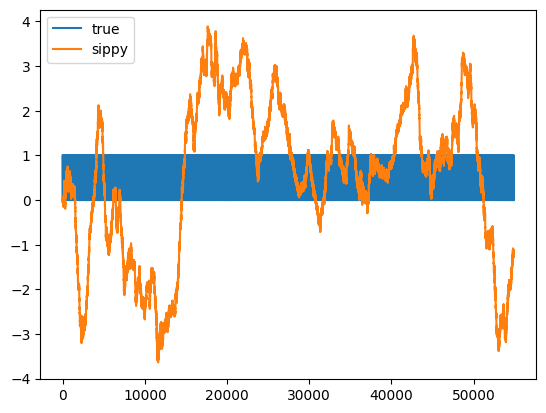

In [20]:
plt.figure()
plt.plot(y[0, :], label='true')
# plt.xlim()
xid, yid = fsetSIM.SS_lsim_process_form(sys_id.A, sys_id.B, sys_id.C, sys_id.D, u, sys_id.x0)
plt.plot(yid[0, :], label='sippy');
plt.legend()

In [21]:
print(y_tot.shape) # Output shape from their example
print(U.shape)     # Input shape from their example

print(y.shape)     # Our data
print(u.shape)

print(yid.shape)   # Shape of the predicted outputs

(1, 501)
(2, 501)
(1, 54883)
(4, 54883)
(1, 54883)


In [22]:
np.savez('./fit_params/sippy_gausslds_fit.npz', Ahat=sys_id.A, Bhat=sys_id.B, Chat=sys_id.C, Dhat=sys_id.D)

## Model comparison

In [27]:
seeds = ['1378', '2299', '3107', '3639', '4454', '4601', '4671', '6902', '7327', '8670']
seeds = [int(seed) for seed in seeds]
seed = seeds[9]

d = np.load('../data/model-comparisons/dataA/datasetA/datasetA_large-%d.npz' % seed)

# for key in d.keys():
#     print(key)
    
u_train = d['u_train']
y_train = d['y_train']
u_test = d['u_test']
y_test = d['y_test']

A = d['A']
print(y_train.shape)
print(u_train.shape)

(204800, 1, 5)
(204800, 3, 5)


In [28]:
num_folds = 5
m = u_train.shape[-1]
q = y_train.shape[-1]
p = A.shape[0]

for fold in range(num_folds):
    print(fold)
#     u = u_train[fold, :, :].T
#     y = y_train[fold, :, :].T
    u = u_train[:, :, fold].T
    y = y_train[:, :, fold].T
    
    try:
        sys_id = system_identification(y, u, 'N4SID', SS_fixed_order = p, SS_D_required=True)
    except:
        print('huh?')
        continue
    
    savemat('../data/model-comparisons/dataA/datasetA/datasetA_large-%d_gaussian_fold%d.mat' % (seed, fold), {'Ahat':sys_id.A, 
             'Bhat':sys_id.B, 'Chat':sys_id.C, 'Dhat':sys_id.D,
             'u_train':u_train, 'u_test':u_test, 'y_train':y_train, 'y_test':y_test,
             'A':d['A'], 'B':d['B'], 'C':d['C'], 'D':d['D'], 'Q':d['Q']})

0
1
2
3
4


## Real data

In [17]:
# Load real data
d = np.load('../data/real-data/baseline-performance/train_test_info.npz', allow_pickle=True)

for key in d.keys():
    print(key)
    
y_train = d['y_train']
y_test = d['y_test']
u_train = d['u_train']
u_test = d['u_test']
sessions_train = d['sessions_train']
sessions_test = d['sessions_test']
trials_test = d['trials_test']
seeds = d['seeds']

p = 3
m = 4
k = 30
q = 1
nfolds = 5
# y = 1 - np.nonzero(y)[1][np.newaxis]
# inputs = np.load('../data/real-data/d2mice_inputs.npy')

y_train
y_test
u_train
u_test
sessions_train
sessions_test
trials_test
seeds


In [20]:
A = np.zeros((nfolds, p, p))
B = np.zeros((nfolds, p, m))
C = np.zeros((nfolds, q, p))
D = np.zeros((nfolds, q, m))
Q = np.zeros((nfolds, p, p))

for fold in range(5):
    u = u_train[fold].T
    y = y_train[fold].T
    sys_id = system_identification(y, u, 'N4SID', SS_fixed_order = p, SS_f = k, SS_D_required=True)
    
    A[fold, :, :] = sys_id.A
    B[fold, :, :] = sys_id.B
    C[fold, :, :] = sys_id.C
    D[fold, :, :] = sys_id.D
    Q[fold, :, :] = sys_id.Q
    
param_dict = {'A' : A, 'B' : B, 'C' : C, 'D' : D, 'Q' : Q, 'y_train' : y_train, 'y_test' : y_test,
              'u_train' : u_train, 'u_test' : u_test, 'sessions_train' : sessions_train, 
              'sessions_test' : sessions_test, 'trials_test' : trials_test, 'seeds' : seeds}
savemat('../data/real-data/baseline-performance/gaussian_train_params.mat', param_dict)
    

## EM

In [4]:
import scipy.io as sio

for i in range(7):
    # Load real data
    d = np.load('../data/em-inits/datasetG_q1/bestLDS-smallC-%d.npz' % i)
    y = d['y']
    u = d['u']
    p = d['A'].shape[0]
    k = p
    
    try:
        sys_id = system_identification(y, u, 'N4SID', SS_fixed_order = p, SS_f = k, SS_D_required=True)
    except:
        print(i)
        continue
        
    np.savez('../data/em-inits/datasetG_q1/gaussian-smallC-%d.npz' % i, Ahat=sys_id.A, Bhat=sys_id.B, 
             Chat=sys_id.C, Dhat=sys_id.D, Qhat=sys_id.Q, seed=d['seed'], A=d['A'], B=d['B'], C=d['C'], 
             C_new=d['C_new'], D=d['D'], Q=d['Q'], Q0=d['Q0'], x0=d['x0'], muu=d['muu'], 
             Qu=d['Qu'], y=y, z=d['z'], u=u, x=d['x'])
    
    data_dict = {}
    for key in d.keys():
        data_dict[key] = d[key]
        
    data_dict['Ahat'] = sys_id.A
    data_dict['Bhat'] = sys_id.B
    data_dict['Chat'] = sys_id.C
    data_dict['Dhat'] = sys_id.D
    data_dict['Qhat'] = sys_id.Q
    
    sio.savemat('../data/em-inits/datasetG_q1/gaussian-smallC-%d.mat' % i, data_dict)

In [7]:
y = np.load('../data/real-data/d2mice_outputs.npy')
y = 1-np.nonzero(y)[1][np.newaxis].T
inputs = np.load('../data/real-data/d2mice_inputs.npy')

q = y.shape[1] # number of observation dimensions
k = 30 # pick sufficiently large hankel size
p = 3
m = 4
u = np.hstack((inputs[:,0:2],inputs[:,-2:]))

# run n4sid
sys_id = system_identification(y, u, 'N4SID', SS_fixed_order = p, SS_D_required=True)#, SS_f = k)

data_dict = {'y' : y, 'u' : u, 'p' : p, 'q' : q, 'm' : m, 'k' : k,
             'Ahat' : sys_id.A, 'Bhat' : sys_id.B, 'Chat' : sys_id.C, 'Dhat' : sys_id.D, 'Qhat' : sys_id.Q}
savemat('../data/real-data/gaussian-allfit.mat', data_dict)

In [10]:
sys_id.A

array([[ 9.99170462e-01, -2.77430690e-02,  2.34009720e-01],
       [ 2.93212273e-03,  3.61689545e-01, -1.11149051e+00],
       [ 1.07448912e-03, -2.89933579e-02,  3.13756786e-01]])